# 1.1 Analisis Exploratorio de datos

Cargamos los datos inicialmente

In [76]:
import pandas as pd

data_path = 'data/home_data.csv'
df = pd.read_csv(data_path)

# vemos el esquema del Dataframe para darnos una idea inicial de las columnas y tipos de datos
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Podemos ver que tenemos un dataframe con 21613 registros, 21 columnas, y que no hay valores nulos en cada columna inicialmente

Para el EDA, Personalmente me gusta usar una libreria llamada ydata_profiling, allí puedo evaluar de manera integra la estructura de los datos en un .html que se genera

In [77]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="data_precio_viviendas ")
profile.to_file("data_precio_viviendas.html")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


Podemos ver el resumen estadistico del df, el tipo de variables y la cantidad de memoria que ocupa el dataset

![overview](img/overview.png)

además podemos ver un resumen por cada columna para identificar aspectos importantes:

columna id

![id](img/resumenId.png)

columna Price

![price](img/resumenPrice.png)

columna bathrooms

![bathroom](img/resumenBathrooms.png)

columna Bedrooms

![bedrooms](img/resumenBedrooms.png)

columna floors

![floors](img/resumenFloors.png)

columna sqft_above

![sqft_above](img/resumensqft_above.png)

columna sqft_basement

![sqft_basement](img/resumensqft_basement.png)

columna sqft_living

![sqft_living](img/resumensqft_living.png)

columna sqtf_lot

![sqft_lot](img/resumensqft_lot.png)

![correlaciones](img/resumenCorrelaciones.png)



In [78]:
# exploremos las correlaciones solo del precio con las demás variables numéricas
numeric_df = df.select_dtypes(include=['number'])

# Calcular correlaciones con 'price'
correlations = numeric_df.corr()['price'].sort_values(ascending=False)

print("\n🔗 Top 10 Correlaciones con el Precio:")
print(correlations.head(11))


🔗 Top 10 Correlaciones con el Precio:
price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
Name: price, dtype: float64



## conclusiones 1.1 EDA 
* existen algunos registros duplicados en el id que se tienen que depurar en la parte subsiguiente de preprocesamiento de datos
* es necesario cambiar el tipo de dato de la columna bathrooms y floors ya que al ser baños y pisos respectivamente, no pueden existir decimales, se debe redondear al entero más cercano y convertir a tipo int
* depurar los outliers de la columna bedrooms ya que hay algunos registros que presentan hasta 33 dormitorios, lo cual puede sesgar los modelos, es necesario eliminarlos
* depurar los outliers de la columna sqft_lot ya que existen valores muy altos que no permiten conocer bien la distribucion de los datos y generan sesgos
* adicionalmente:
   - Relación no lineal entre algunas variables y precio
   - Posible multicolinealidad entre variables de área
   - sqft_living: Correlación más fuerte con precio (>0.7)
   - grade: segunda relacion más fuerte, aunque no se explica mucho que es esta variable, es importante.


# 1.2 preprocesamiento datos

Miremos cuantos duplicados hay en la columna "id", deberían tener valores unicos

In [79]:
duplicados = df[df.duplicated(subset='id', keep=False)]
print(f"Número de registros duplicados por 'id': {duplicados['id'].nunique()}")

Número de registros duplicados por 'id': 176


Aqui nos dimos cuenta que hay varios registros duplicados, miremos inicialmente cual puede ser el motivo

In [80]:
# genero un array con los ids duplicados
duplicados_ids = df['id'][df['id'].duplicated()].unique()

# quiero ver un ejemplo de los duplicados
id_ejemplo = duplicados_ids[2]
df_id = df[df['id'] == id_ejemplo]
df_id

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
324,7520000520,20140905T000000,232000,2,1.0,1240,12092,1.0,0,0,...,6,960,280,1922,1984,98146,47.4957,-122.352,1820,7460
325,7520000520,20150311T000000,240500,2,1.0,1240,12092,1.0,0,0,...,6,960,280,1922,1984,98146,47.4957,-122.352,1820,7460


a priori parece que las columnas que difieren son la fecha y el precio, lo cual sugiere que hay registros en los que se actualizó el precio del inmueble en una fecha posterior, validemos esta hipótesis para todos los registros

In [81]:
diferencias = {}

for _id in duplicados_ids:
    filas = df[df['id'] == _id]
    if len(filas) > 1:
        diff = filas.loc[filas.index[0]] != filas.loc[filas.index[1]]
        cols_diff = diff[diff].index.tolist()
        diferencias[_id] = cols_diff

# Mostrar IDs y columnas distintas
for k, v in list(diferencias.items())[:10]:  # solo los primeros 10 para no saturar
    print(f"ID {k} difiere en: {v}")

ID 6021501535 difiere en: ['date', 'price']
ID 4139480200 difiere en: ['date', 'price']
ID 7520000520 difiere en: ['date', 'price']
ID 3969300030 difiere en: ['date', 'price']
ID 2231500030 difiere en: ['date', 'price']
ID 8820903380 difiere en: ['date', 'price']
ID 726049190 difiere en: ['date', 'price']
ID 8682262400 difiere en: ['date', 'price']
ID 9834200885 difiere en: ['date', 'price']
ID 8062900070 difiere en: ['date', 'price']


Efectivamente, las columnas que hacen que estén duplicados son por fecha y precio, como queremos generar un modelo de precios, eliminaremos los registros viejos y dejaremos los mas recientes

ordenamos entonces el dataframe para dejar los registros más actualizados.



In [82]:
# Ordenar por id y fecha (de más reciente a más antigua)
df_sorted = df.sort_values(['id', 'date'], ascending=[True, False])

# Eliminar duplicados, manteniendo SOLO el registro más reciente
df_clean = df_sorted.drop_duplicates(subset='id', keep='first')

# eliminiamos también el que tuvo 33 bedrooms porque es un error obvio
df_clean = df_clean[df_clean['bedrooms'] < 33]

#convertimos la columna date a tipo fecha
df_clean['date'] = df_clean['date'].astype(str)

# convierto a tipo int la columna de bathrooms y floors 
df_clean['bathrooms'] = df_clean['bathrooms'].astype(int)
df_clean['floors'] = df_clean['floors'].astype(int)

In [83]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df_clean, title="precio vivendas depurado ")
profile.to_file("data_precio_viviendas_depurado.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 26.21it/s]


A partir de acá guardo en un archivo .parquet el dataset ya depurado

In [84]:
df_clean.to_parquet('data/home_data_clean.parquet', index=False,engine='fastparquet')
#df_clean.info()

## Conclusiones 1.2 Preprocesamiento de datos:
* se eliimnaron id's duplicados
* se eliminaron los outliers que no tenian sentido como los 33 bedrooms
* variables como floors o bathrooms se transformaron a enteros debido a la naturaleza del dato

# 1.3 Modelo para ajustar el precio de las viviendas

In [85]:
# haremos tratamientos adicionales al set de datos crudos para el modelado, no se hicieron antes para poder analizar los datos en su estado original.
# 2.2 Tratamiento de outliers en precio

# Crear copia para preprocesamiento
df_processed = df_clean.copy()

# seremos laxos con estos outliers, eliminando solo los que están muy fuera de rango
Q1 = df_processed['price'].quantile(0.15)
Q3 = df_processed['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers_before = len(df_processed)
df_processed = df_processed[(df_processed['price'] >= lower_bound) & 
                            (df_processed['price'] <= upper_bound)]
outliers_removed = outliers_before - len(df_processed)
print(f"   - Outliers removidos: {outliers_removed} ({outliers_removed/outliers_before*100:.2f}%)")

   - Outliers removidos: 314 (1.46%)


In [86]:
#creo variables nuevas para mejorar el modelado y la predicción
# Edad de la vivienda
if 'yr_built' in df_processed.columns:
    df_processed['house_age'] = 2025 - df_processed['yr_built']
    print("   - Creada: house_age (edad de la vivienda)")

# Fue renovada
if 'yr_renovated' in df_processed.columns:
    df_processed['is_renovated'] = (df_processed['yr_renovated'] > 0).astype(int)
    print("   - Creada: is_renovated (indicador de renovación)")


# Ratio baños/habitaciones
if 'bathrooms' in df_processed.columns and 'bedrooms' in df_processed.columns:
    df_processed['bath_bed_ratio'] = df_processed['bathrooms'] / (df_processed['bedrooms'] + 1)
    print("   - Creada: bath_bed_ratio (ratio baños/habitaciones)")

# Eliminar columnas no relevantes o de identificación
columns_to_drop = ['id', 'date', 'lat','long', 'zipcode']
existing_drops = [col for col in columns_to_drop if col in df_processed.columns]
df_processed = df_processed.drop(columns=existing_drops)
print(f"   - Columnas eliminadas: {existing_drops}")

   - Creada: house_age (edad de la vivienda)
   - Creada: is_renovated (indicador de renovación)
   - Creada: bath_bed_ratio (ratio baños/habitaciones)
   - Columnas eliminadas: ['id', 'date', 'lat', 'long', 'zipcode']


In [87]:
df_processed.head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,house_age,is_renovated,bath_bed_ratio
2497,300000,6,3,2400,9373,2,0,0,3,7,2400,0,1991,0,2060,7316,34,0,0.428571
6735,647500,4,1,2060,26036,1,0,0,4,8,1160,900,1947,0,2590,21891,78,0,0.200000
8411,400000,3,1,1460,43000,1,0,0,3,7,1460,0,1952,0,2250,20023,73,0,0.250000
8809,235000,3,1,1430,7599,1,0,0,4,6,1010,420,1930,0,1290,10320,95,0,0.250000
3557,402500,4,2,1650,3504,1,0,0,3,7,760,890,1951,2013,1480,3504,74,1,0.400000


usaremos varios modelos para ver cual se nos puede ajustar más y miraremos las predicciones con cada modelo

* Regresión lineal
* Regresión Ridge
* Regresión Lasso
* Random forest
* Gradient Boosting

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Dividimos los datos en conjunto de entrenamiento y prueba
X = df_processed.drop('price', axis=1) # Caracteristicas
y = df_processed['price'] # Objetivo a predecir

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"   - Train set: {X_train.shape[0]} muestras")
print(f"   - Test set: {X_test.shape[0]} muestras")

   - Train set: 16896 muestras
   - Test set: 4225 muestras


In [89]:
#Estandarizamos las caracteristicas para normalizar los datos y que los valores esten en la misma escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"""
- Datos originales: {outliers_before:,} filas
- Datos procesados: {len(df_processed):,} filas
- Características finales: {X_train.shape[1]}
- Nuevas features creadas: 4
- Estrategia de escalado: StandardScaler
""")


- Datos originales: 21,435 filas
- Datos procesados: 21,121 filas
- Características finales: 18
- Nuevas features creadas: 4
- Estrategia de escalado: StandardScaler



COMO PREMISA TOMAREMOS LA SIGUIENTE ESTRATEGIA DE INVERSIÓN:

Una vivienda es atractiva para inversión cuando:
1. El precio de mercado está SUB-VALUADO respecto a la predicción del modelo
2. Tiene características deseables (buena ubicación, condición, tamaño)
3. El diferencial entre precio predicho y real es significativo (>30%)

Fórmula: Potencial de Inversión = (Precio Predicho - Precio Real) / Precio Real * 100


#### EVALUEMOS PRIMERO EL MODELO DE REGRESION LINEAL

   - ERROR CUADRATICO MEDIO: $164,578.02
   - ERROR ABSOLUTO MEDIO: $120,307.58
   - R²: 0.6389
Precio promedio: $541,645.37
Desviación estándar: $367,322.88
Mínimo: $75,000.00
Máximo: $7,700,000.00


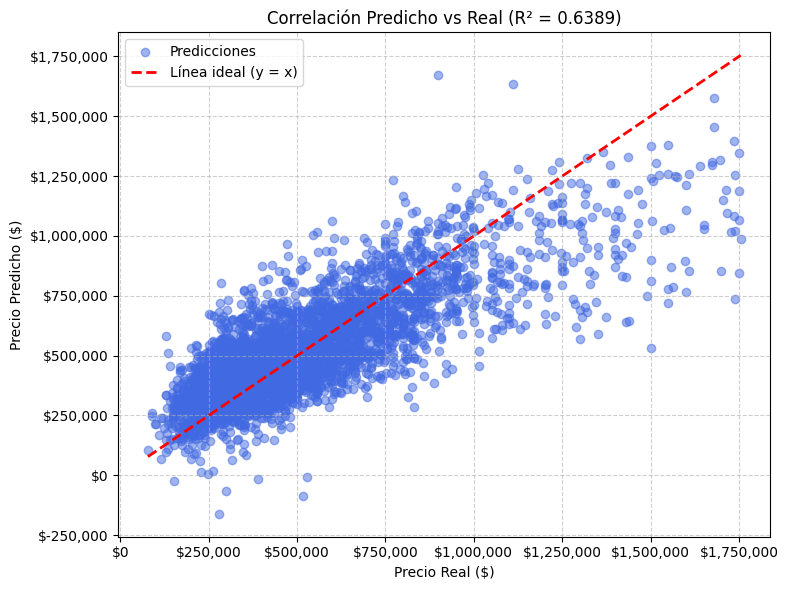

In [90]:
%matplotlib inline
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

results = {}
lr = LinearRegression()
# Entrenamos el modelo
lr.fit(X_train_scaled, y_train)
# Hacemos predicciones
y_pred = lr.predict(X_test_scaled)
# Evaluamos el modelo

results['Linear Regression'] = {
    'model': lr,
    'y_pred': y_pred,
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'mae': mean_absolute_error(y_test, y_pred),
    'r2': r2_score(y_test, y_pred),
    'cv_score': cross_val_score(lr, X_train_scaled, y_train, cv=5, 
                                 scoring='neg_mean_squared_error').mean()
}

print(f"   - ERROR CUADRATICO MEDIO: ${results['Linear Regression']['rmse']:,.2f}")
print(f"   - ERROR ABSOLUTO MEDIO: ${results['Linear Regression']['mae']:,.2f}")
print(f"   - R²: {results['Linear Regression']['r2']:.4f}")


mean_price = df_clean['price'].mean()
std_price = df_clean['price'].std()
min_price = df_clean['price'].min()
max_price = df_clean['price'].max()

print(f"Precio promedio: ${mean_price:,.2f}")
print(f"Desviación estándar: ${std_price:,.2f}")
print(f"Mínimo: ${min_price:,.2f}")
print(f"Máximo: ${max_price:,.2f}")



plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Línea ideal (y = x)')

plt.title(f"Correlación Predicho vs Real (R² = {results['Linear Regression']['r2']:.4f})")
plt.xlabel("Precio Real ($)")
plt.ylabel("Precio Predicho ($)")

# Ejes con formato de miles y signo $
plt.ticklabel_format(style='plain', axis='both')  # elimina notación científica
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:,.0f}'))

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

C:\Users\jonat\AppData\Local\Temp\ipykernel_16348\1788835445.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jonat\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


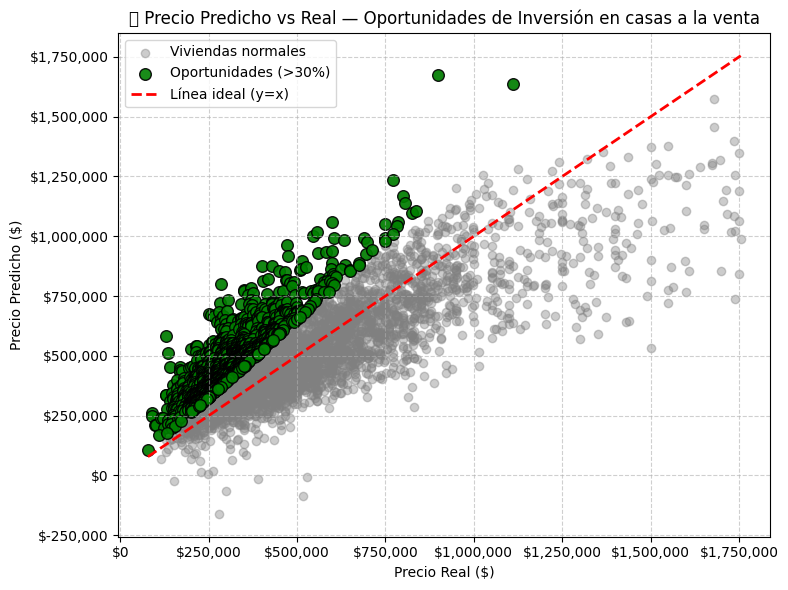

In [91]:
# Crear DataFrame de inversión
investment_df = X_test.copy()
investment_df['precio_real'] = y_test.values
investment_df['precio_predicho'] = y_pred
investment_df['diferencia'] = investment_df['precio_predicho'] - investment_df['precio_real']  # si la diferencia es positiva, está subvaluada
investment_df['potencial_pct'] = (investment_df['diferencia'] / investment_df['precio_real']) * 100

# Filtrar oportunidades (subvaluadas > 10%)
opportunities = investment_df[investment_df['potencial_pct'] > 30].sort_values(
    'potencial_pct', ascending=False
)

preds_df = investment_df.copy()
preds_df.rename(columns={'precio_real': 'price_true', 'precio_predicho': 'price_pred'}, inplace=True)

plt.figure(figsize=(8,6))
plt.scatter(preds_df['price_true'], preds_df['price_pred'], 
            alpha=0.4, color='gray', label='Viviendas normales')

# Resaltar oportunidades de inversión
plt.scatter(opportunities['precio_real'], opportunities['precio_predicho'], 
            alpha=0.9, color='green', s=70, edgecolor='black', label='Oportunidades (>30%)')

# Línea ideal
plt.plot([preds_df['price_true'].min(), preds_df['price_true'].max()],
         [preds_df['price_true'].min(), preds_df['price_true'].max()],
         'r--', lw=2, label='Línea ideal (y=x)')

plt.title("📊 Precio Predicho vs Real — Oportunidades de Inversión en casas a la venta")
plt.xlabel("Precio Real ($)")
plt.ylabel("Precio Predicho ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Formato de ejes con $ y sin notación científica
plt.ticklabel_format(style='plain', axis='both')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:,.0f}'))

plt.tight_layout()
plt.show()

#### EVALUEMOS REGRESION RIDGE

In [92]:
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt



ridge = Ridge(alpha=10)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)


results['Ridge'] = {
    'model': ridge,
    'y_pred': y_pred_ridge,
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    'mae': mean_absolute_error(y_test, y_pred_ridge),
    'r2': r2_score(y_test, y_pred_ridge),
    'cv_score': cross_val_score(ridge, X_train_scaled, y_train, cv=5,
                                 scoring='neg_mean_squared_error').mean()
}
print("Ridge Regression Results:")
print(f"   - ERROR CUADRATICO MEDIO: ${results['Ridge']['rmse']:,.2f}")
print(f"   - ERROR ABSOLUTO MEDIO: ${results['Ridge']['mae']:,.2f}")
print(f"   - R²: {results['Ridge']['r2']:.4f}")

print("Linear regression:")
print(f"   - ERROR CUADRATICO MEDIO: ${results['Linear Regression']['rmse']:,.2f}")
print(f"   - ERROR ABSOLUTO MEDIO: ${results['Linear Regression']['mae']:,.2f}")
print(f"   - R²: {results['Linear Regression']['r2']:.4f}")

Ridge Regression Results:
   - ERROR CUADRATICO MEDIO: $164,866.57
   - ERROR ABSOLUTO MEDIO: $120,605.40
   - R²: 0.6376
Linear regression:
   - ERROR CUADRATICO MEDIO: $164,578.02
   - ERROR ABSOLUTO MEDIO: $120,307.58
   - R²: 0.6389


C:\Users\jonat\AppData\Local\Temp\ipykernel_16348\3589956064.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jonat\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


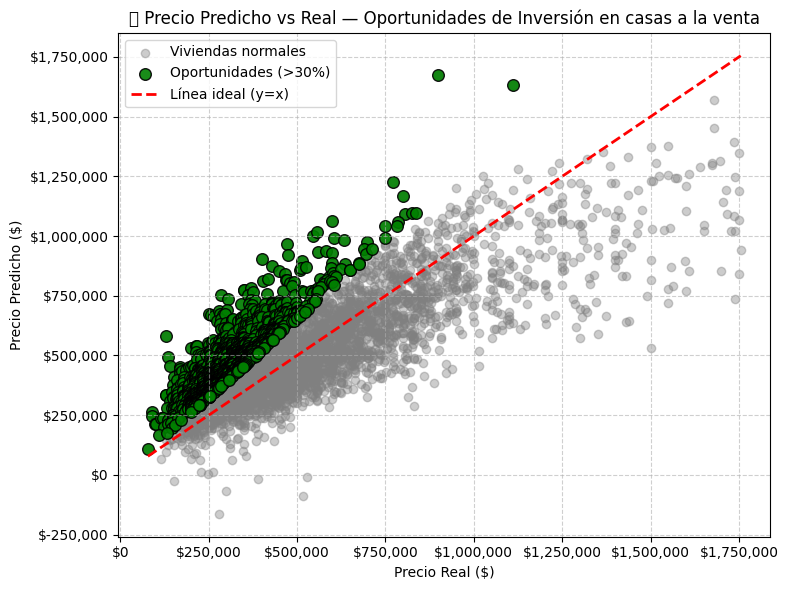

In [93]:
# Crear DataFrame de inversión
investment_df = X_test.copy()
investment_df['precio_real'] = y_test.values
investment_df['precio_predicho'] = y_pred_ridge
investment_df['diferencia'] = investment_df['precio_predicho'] - investment_df['precio_real']  # si la diferencia es positiva, está subvaluada
investment_df['potencial_pct'] = (investment_df['diferencia'] / investment_df['precio_real']) * 100

# Filtrar oportunidades (subvaluadas > 10%)
opportunities = investment_df[investment_df['potencial_pct'] > 30].sort_values(
    'potencial_pct', ascending=False
)

preds_df = investment_df.copy()
preds_df.rename(columns={'precio_real': 'price_true', 'precio_predicho': 'price_pred'}, inplace=True)

plt.figure(figsize=(8,6))
plt.scatter(preds_df['price_true'], preds_df['price_pred'], 
            alpha=0.4, color='gray', label='Viviendas normales')

# Resaltar oportunidades de inversión
plt.scatter(opportunities['precio_real'], opportunities['precio_predicho'], 
            alpha=0.9, color='green', s=70, edgecolor='black', label='Oportunidades (>30%)')

# Línea ideal
plt.plot([preds_df['price_true'].min(), preds_df['price_true'].max()],
         [preds_df['price_true'].min(), preds_df['price_true'].max()],
         'r--', lw=2, label='Línea ideal (y=x)')

plt.title("📊 Precio Predicho vs Real — Oportunidades de Inversión en casas a la venta")
plt.xlabel("Precio Real ($)")
plt.ylabel("Precio Predicho ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Formato de ejes con $ y sin notación científica
plt.ticklabel_format(style='plain', axis='both')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:,.0f}'))

plt.tight_layout()
plt.show()

## Evaluemos RandomForest


Linear regression:
   - ERROR CUADRATICO MEDIO: $164,578.02
   - ERROR ABSOLUTO MEDIO: $120,307.58
   - R²: 0.6389
Ridge Regression Results:
   - ERROR CUADRATICO MEDIO: $164,866.57
   - ERROR ABSOLUTO MEDIO: $120,605.40
   - R²: 0.6376
Random Forest:
   - ERROR CUADRATICO MEDIO: $143,036.90
   - ERROR ABSOLUTO MEDIO: $102,835.02
   - R²: 0.7273


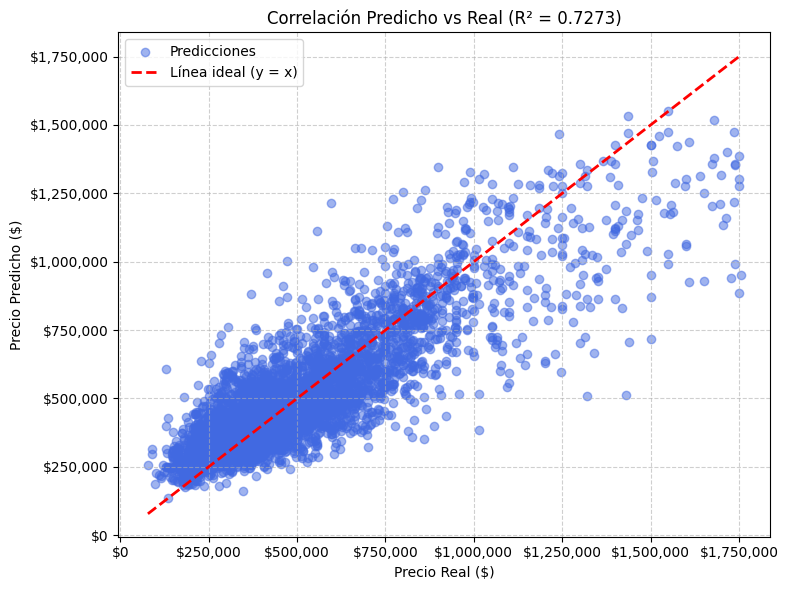

In [99]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

results['Random Forest'] = {
    'model': rf,
    'y_pred': y_pred_rf,
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_rf)),
    'mae': mean_absolute_error(y_test, y_pred_rf),
    'r2': r2_score(y_test, y_pred_rf),
    'cv_score': cross_val_score(rf, X_train, y_train, cv=5,
                                 scoring='neg_mean_squared_error').mean()
}

print("Linear regression:")
print(f"   - ERROR CUADRATICO MEDIO: ${results['Linear Regression']['rmse']:,.2f}")
print(f"   - ERROR ABSOLUTO MEDIO: ${results['Linear Regression']['mae']:,.2f}")
print(f"   - R²: {results['Linear Regression']['r2']:.4f}")


print("Ridge Regression Results:")
print(f"   - ERROR CUADRATICO MEDIO: ${results['Ridge']['rmse']:,.2f}")
print(f"   - ERROR ABSOLUTO MEDIO: ${results['Ridge']['mae']:,.2f}")
print(f"   - R²: {results['Ridge']['r2']:.4f}")


print("Random Forest:")
print(f"   - ERROR CUADRATICO MEDIO: ${results['Random Forest']['rmse']:,.2f}")
print(f"   - ERROR ABSOLUTO MEDIO: ${results['Random Forest']['mae']:,.2f}")
print(f"   - R²: {results['Random Forest']['r2']:.4f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='royalblue', label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Línea ideal (y = x)')

plt.title(f"Correlación Predicho vs Real (R² = {results['Random Forest']['r2']:.4f})")
plt.xlabel("Precio Real ($)")
plt.ylabel("Precio Predicho ($)")

# Ejes con formato de miles y signo $
plt.ticklabel_format(style='plain', axis='both')  # elimina notación científica
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:,.0f}'))

plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [101]:
# Calcula el R² en los datos de entrenamiento
r2_train = rf.score(X_train, y_train)

print(f"R² en Entrenamiento: {r2_train:.4f}")
print(f"R² en Prueba: {results['Random Forest']['r2']:.4f}")

R² en Entrenamiento: 0.9501
R² en Prueba: 0.7273


Importancia de cada característica:
           Feature  Importance
8            grade    0.428816
2      sqft_living    0.157373
13   sqft_living15    0.078062
11        yr_built    0.061725
15       house_age    0.061114
14      sqft_lot15    0.054099
3         sqft_lot    0.045700
9       sqft_above    0.031915
10   sqft_basement    0.016392
6             view    0.014404
17  bath_bed_ratio    0.012805
7        condition    0.010607
0         bedrooms    0.009140
1        bathrooms    0.004869
4           floors    0.004519
12    yr_renovated    0.003700
5       waterfront    0.003608
16    is_renovated    0.001155


C:\Users\jonat\AppData\Local\Temp\ipykernel_16348\2277901198.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


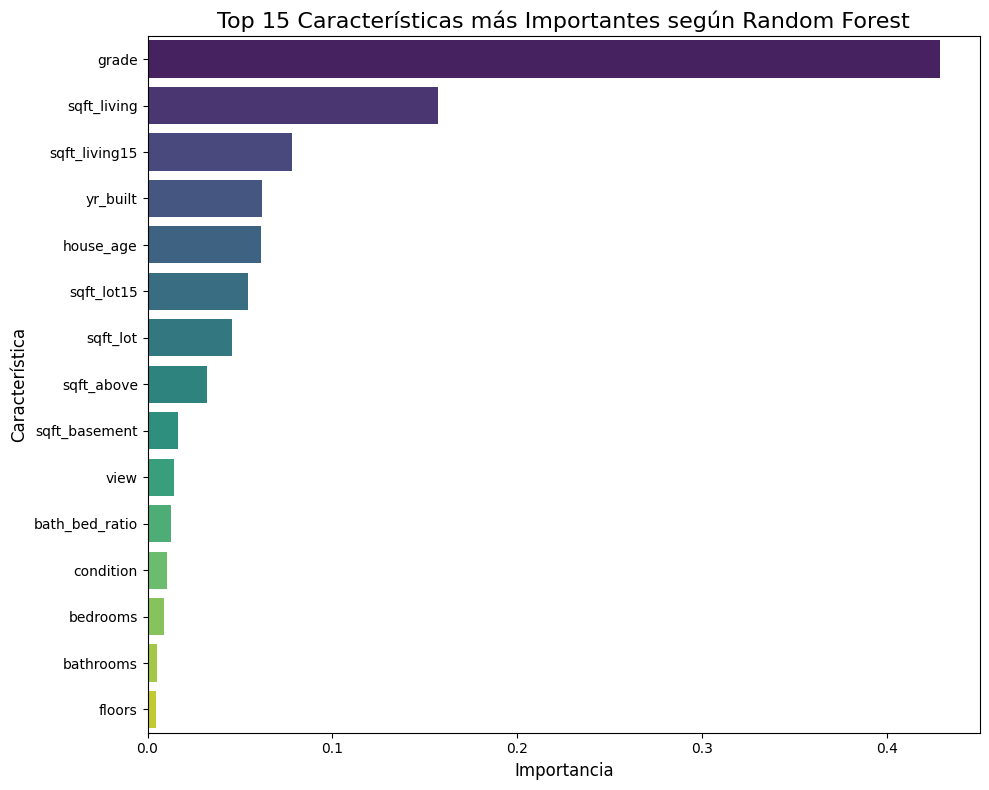

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Extracción de Datos del Modelo ---
# Extraer las importancias de las características del modelo RandomForest ya entrenado.
importances = rf.feature_importances_
# Obtener los nombres de las columnas de tus datos de entrenamiento.
feature_names = X_train.columns

# --- Creación de la Tabla de Importancia ---
# Crear un DataFrame de pandas para asociar cada característica con su importancia.
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False) # Ordenar de mayor a menor importancia.

# Imprimir la tabla en la consola.
print("Importancia de cada característica:")
print(feature_importance_df)

# --- Visualización de las Características Más Importantes ---
# Seleccionar solo las 15 características más importantes para que el gráfico sea legible.
top_features = feature_importance_df.head(15)

# Crear la figura y los ejes para el gráfico.
plt.figure(figsize=(10, 8))

# Usar seaborn para crear un gráfico de barras horizontales atractivo.
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')

# Añadir títulos y etiquetas para mayor claridad.
plt.title('Top 15 Características más Importantes según Random Forest', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Característica', fontsize=12)

# Ajustar el diseño y mostrar el gráfico.
plt.tight_layout()
plt.show()

C:\Users\jonat\AppData\Local\Temp\ipykernel_16348\2524443680.py:40: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jonat\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


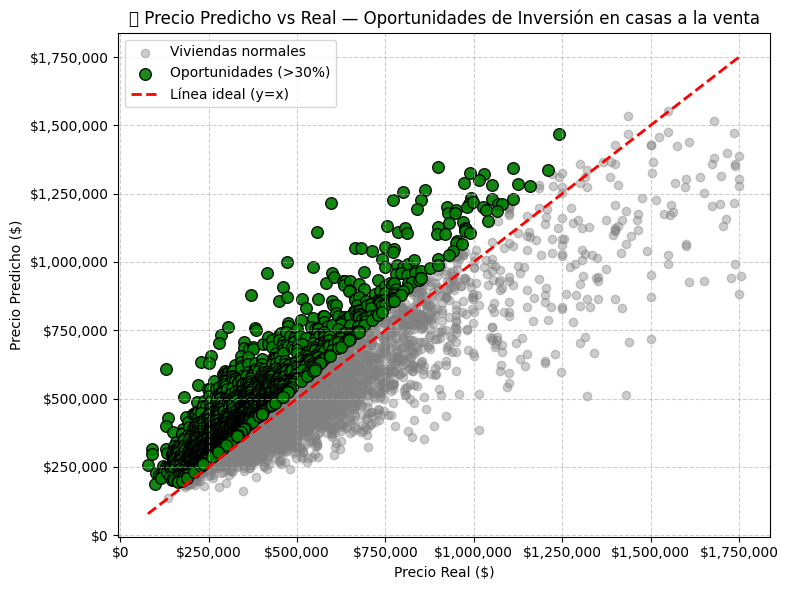

In [103]:
# Crear DataFrame de inversión
investment_df = X_test.copy()
investment_df['precio_real'] = y_test.values
investment_df['precio_predicho'] = y_pred_rf
investment_df['diferencia'] = investment_df['precio_predicho'] - investment_df['precio_real']  # si la diferencia es positiva, está subvaluada
investment_df['potencial_pct'] = (investment_df['diferencia'] / investment_df['precio_real']) * 100

# Filtrar oportunidades (subvaluadas > 10%)
opportunities = investment_df[investment_df['potencial_pct'] > 10].sort_values(
    'potencial_pct', ascending=False
)

preds_df = investment_df.copy()
preds_df.rename(columns={'precio_real': 'price_true', 'precio_predicho': 'price_pred'}, inplace=True)

plt.figure(figsize=(8,6))
plt.scatter(preds_df['price_true'], preds_df['price_pred'], 
            alpha=0.4, color='gray', label='Viviendas normales')

# Resaltar oportunidades de inversión
plt.scatter(opportunities['precio_real'], opportunities['precio_predicho'], 
            alpha=0.9, color='green', s=70, edgecolor='black', label='Oportunidades (>30%)')

# Línea ideal
plt.plot([preds_df['price_true'].min(), preds_df['price_true'].max()],
         [preds_df['price_true'].min(), preds_df['price_true'].max()],
         'r--', lw=2, label='Línea ideal (y=x)')

plt.title("📊 Precio Predicho vs Real — Oportunidades de Inversión en casas a la venta")
plt.xlabel("Precio Real ($)")
plt.ylabel("Precio Predicho ($)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Formato de ejes con $ y sin notación científica
plt.ticklabel_format(style='plain', axis='both')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:,.0f}'))

plt.tight_layout()
plt.show()

## ## Evaluemos gradient Boosting

In [105]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

results['Gradient Boosting'] = {
    'model': gb,
    'y_pred': y_pred_gb,
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred_gb)),
    'mae': mean_absolute_error(y_test, y_pred_gb),
    'r2': r2_score(y_test, y_pred_gb),
    'cv_score': cross_val_score(gb, X_train, y_train, cv=5,
                                 scoring='neg_mean_squared_error').mean()
}
print("Linear regression:")
print(f"   - ERROR CUADRATICO MEDIO: ${results['Linear Regression']['rmse']:,.2f}")
print(f"   - ERROR ABSOLUTO MEDIO: ${results['Linear Regression']['mae']:,.2f}")
print(f"   - R²: {results['Linear Regression']['r2']:.4f}")


print("Ridge Regression Results:")
print(f"   - ERROR CUADRATICO MEDIO: ${results['Ridge']['rmse']:,.2f}")
print(f"   - ERROR ABSOLUTO MEDIO: ${results['Ridge']['mae']:,.2f}")
print(f"   - R²: {results['Ridge']['r2']:.4f}")


print("Random Forest:")
print(f"   - ERROR CUADRATICO MEDIO: ${results['Random Forest']['rmse']:,.2f}")
print(f"   - ERROR ABSOLUTO MEDIO: ${results['Random Forest']['mae']:,.2f}")
print(f"   - R²: {results['Random Forest']['r2']:.4f}")

print("Gradient Boosting:")
print(f"   - ERROR CUADRATICO MEDIO: ${results['Gradient Boosting']['rmse']:,.2f}")
print(f"   - ERROR ABSOLUTO MEDIO: ${results['Gradient Boosting']['mae']:,.2f}")
print(f"   - R²: {results['Gradient Boosting']['r2']:.4f}")

Linear regression:
   - ERROR CUADRATICO MEDIO: $164,578.02
   - ERROR ABSOLUTO MEDIO: $120,307.58
   - R²: 0.6389
Ridge Regression Results:
   - ERROR CUADRATICO MEDIO: $164,866.57
   - ERROR ABSOLUTO MEDIO: $120,605.40
   - R²: 0.6376
Random Forest:
   - ERROR CUADRATICO MEDIO: $143,036.90
   - ERROR ABSOLUTO MEDIO: $102,835.02
   - R²: 0.7273
Gradient Boosting:
   - ERROR CUADRATICO MEDIO: $143,482.15
   - ERROR ABSOLUTO MEDIO: $105,698.12
   - R²: 0.7255
